---
title: Superresolution using Random Fourier Features
author: ["Guntas Singh Saran", "Hrriday V. Ruparel"]
date: "2024-03-06"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
image: "output.png"
categories: ["Image Processing"]

---

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from sklearn import preprocessing
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings("ignore")

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

%config InlineBackend.figure_format = "retina"

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

cuda


In [2]:
def save_reconstructed_image(outputs, save_path):
    outputs = outputs.cpu().numpy().clip(0, 1)
    outputs = (outputs * 255).astype(np.uint8)
    pil_image = Image.fromarray(outputs)
    pil_image.save(save_path)

In [3]:
img = torchvision.io.read_image('dog.jpg')
print(img.shape)

torch.Size([3, 1365, 2048])


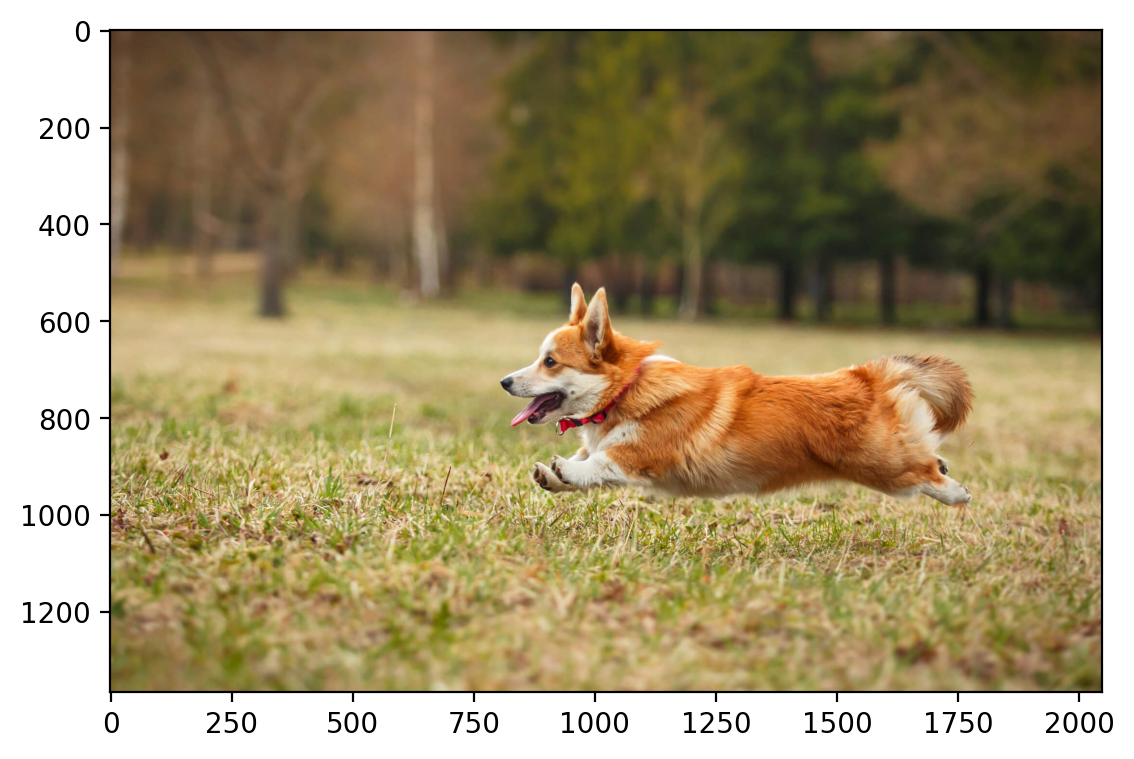

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
img_scaled = preprocessing.MinMaxScaler().fit_transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
print(img_scaled.shape)
print(img_scaled)

torch.Size([3, 1365, 2048])
tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.14

In [6]:
crop = transforms.functional.crop(img_scaled.cpu(), 550, 750, 400, 400)
crop = crop.to(device)
save_reconstructed_image(rearrange(crop, 'c h w -> h w c'), "./SIREN1Dog/Original.png")
print(crop.shape)

torch.Size([3, 400, 400])


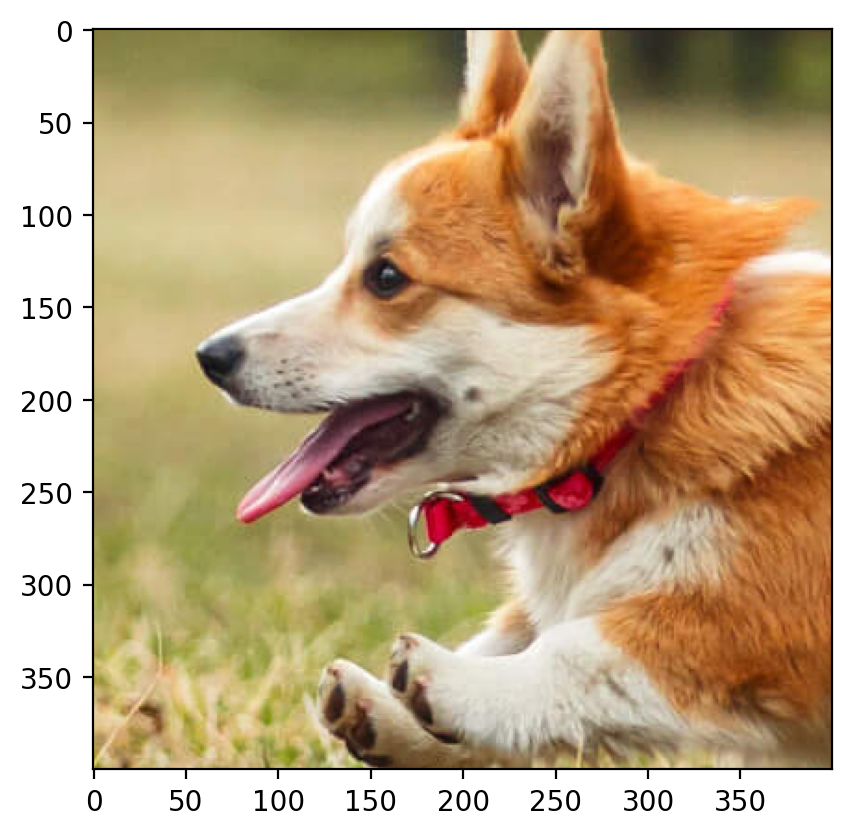

In [7]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

### <center> <b> MAX POOLING </b> </center>
$$ R_{\text{height}} = \frac{A_{\text{height}} + 2\cdot\text{padding} - ker_{\text{height}}}{\text{stride}} + 1 $$
$$ R_{\text{width}} = \frac{A_{\text{width}} + 2\cdot\text{padding} - ker_{\text{width}}}{\text{stride}} + 1 $$

torch.Size([3, 200, 200])


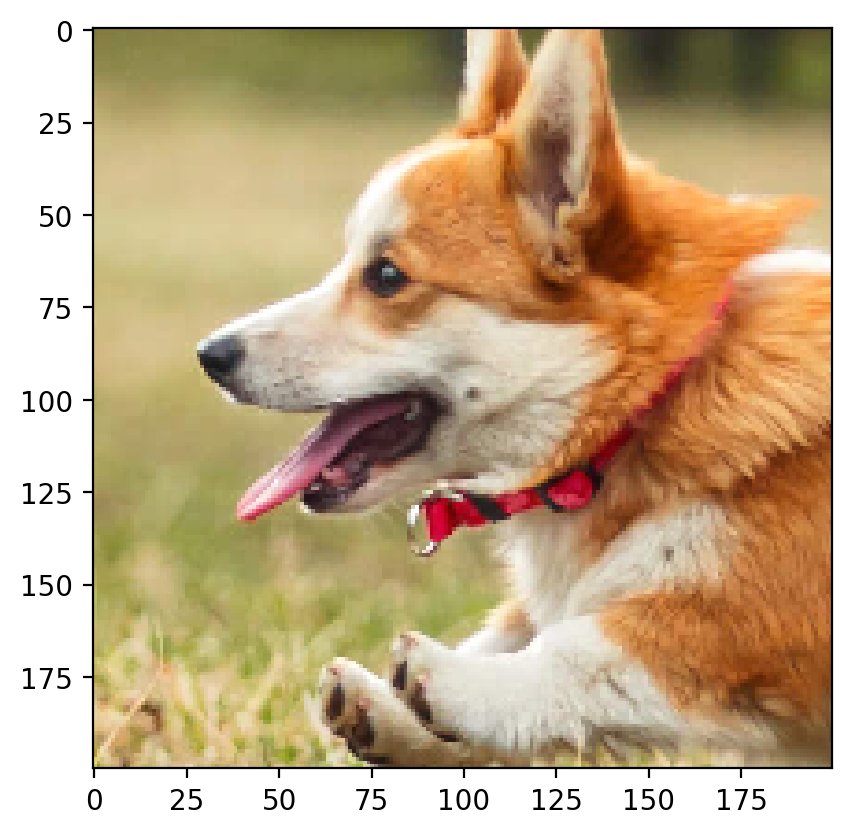

In [8]:
max_pooled = F.max_pool2d(crop.unsqueeze(0), kernel_size = 2, stride = 2)
max_pooled = max_pooled.squeeze(0)
max_pooled = max_pooled.to(device)
save_reconstructed_image(rearrange(max_pooled, 'c h w -> h w c'), "./SIREN1Dog/Pooled.png")
print(max_pooled.shape)
plt.imshow(rearrange(max_pooled, 'c h w -> h w c').cpu().numpy())

In [9]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    
    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [10]:
dog_X, dog_Y = create_coordinate_map(max_pooled)
dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [11]:
print(dog_X[:10, :], '\n', dog_Y[:10, :])

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]], device='cuda:0') 
 tensor([[0.4902, 0.4824, 0.2510],
        [0.5216, 0.4863, 0.2549],
        [0.5216, 0.4863, 0.2549],
        [0.5216, 0.4863, 0.2549],
        [0.5216, 0.4863, 0.2549],
        [0.5176, 0.4941, 0.2510],
        [0.5176, 0.4941, 0.2667],
        [0.5176, 0.4941, 0.2745],
        [0.5176, 0.4902, 0.2784],
        [0.5137, 0.4863, 0.2745]], device='cuda:0')


In [12]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()

In [13]:
dog_X_scaled.shape, dog_X_scaled[:10, :]

(torch.Size([40000, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9899],
         [-1.0000, -0.9799],
         [-1.0000, -0.9698],
         [-1.0000, -0.9598],
         [-1.0000, -0.9497],
         [-1.0000, -0.9397],
         [-1.0000, -0.9296],
         [-1.0000, -0.9196],
         [-1.0000, -0.9095]], device='cuda:0'))

### Simple Single-Layered Fully Connected Linear Neural Network 

In [14]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [15]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [16]:
def plot_reconstructed_and_original_image(original_img, net, X, title = "", scale = 1, allowSave = False, fileName = None):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    height *= scale
    width *= scale
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        
    fig = plt.figure(figsize = (8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    if allowSave and fileName:
        save_reconstructed_image(outputs, fileName)
        
    fig.suptitle(title, y = 0.9)
    plt.tight_layout()

### Adding Random Fourier Features to Single-Layered Fully Connected Neural Network

In [17]:
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state = 42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [18]:
X_rff = create_rff_features(dog_X_scaled, 30000, 0.008)

In [19]:
X_rff.shape

torch.Size([40000, 30000])

In [20]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.01, X_rff, dog_Y, 2000)

Epoch 0 loss: 0.380236
Epoch 100 loss: 0.009829
Epoch 200 loss: 0.003359
Epoch 300 loss: 0.001376
Epoch 400 loss: 0.000631
Epoch 500 loss: 0.000369
Epoch 600 loss: 0.000284
Epoch 700 loss: 0.000258
Epoch 800 loss: 0.000249
Epoch 900 loss: 0.000246
Epoch 1000 loss: 0.000244
Epoch 1100 loss: 0.000242
Epoch 1200 loss: 0.000241
Epoch 1300 loss: 0.000240
Epoch 1400 loss: 0.000239
Epoch 1500 loss: 0.000238
Epoch 1600 loss: 0.000237
Epoch 1700 loss: 0.000237
Epoch 1800 loss: 0.000236
Epoch 1900 loss: 0.000236


0.00023540662368759513

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


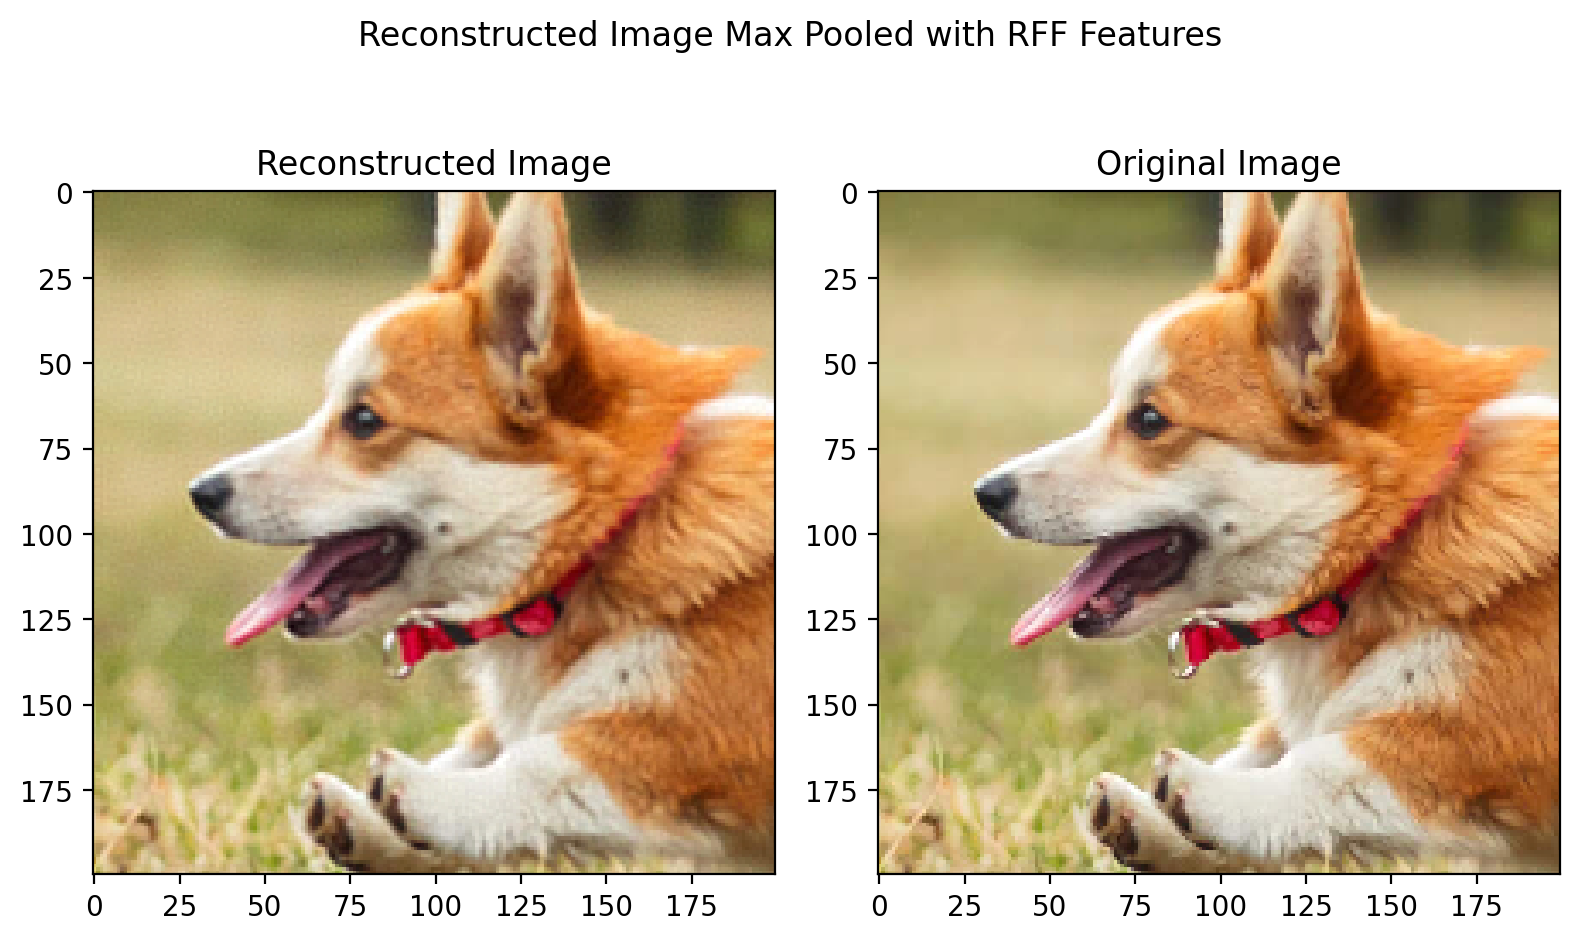

In [21]:
plot_reconstructed_and_original_image(max_pooled, net, X_rff, title = "Reconstructed Image Max Pooled with RFF Features", scale = 1, allowSave = True, fileName = "./SIREN1Dog/Reconstruct.png")

In [22]:
import gc
del X_rff
torch.cuda.empty_cache()
gc.collect()

7365

In [23]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()

    X = X.to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [24]:
dog_X, dog_Y = create_coordinate_map(max_pooled, scale = 2)
print(dog_X.shape, dog_Y.shape)

torch.Size([160000, 2]) torch.Size([40000, 3])


In [25]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()
print(dog_X_scaled.shape)
print(dog_X_scaled[:10, :])

torch.Size([160000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        [-1.0000, -0.9850],
        [-1.0000, -0.9799],
        [-1.0000, -0.9749],
        [-1.0000, -0.9699],
        [-1.0000, -0.9649],
        [-1.0000, -0.9599],
        [-1.0000, -0.9549]], device='cuda:0')


In [26]:
X_rff = create_rff_features(dog_X_scaled, 30000, 0.008)
print(X_rff.shape)

torch.Size([160000, 30000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


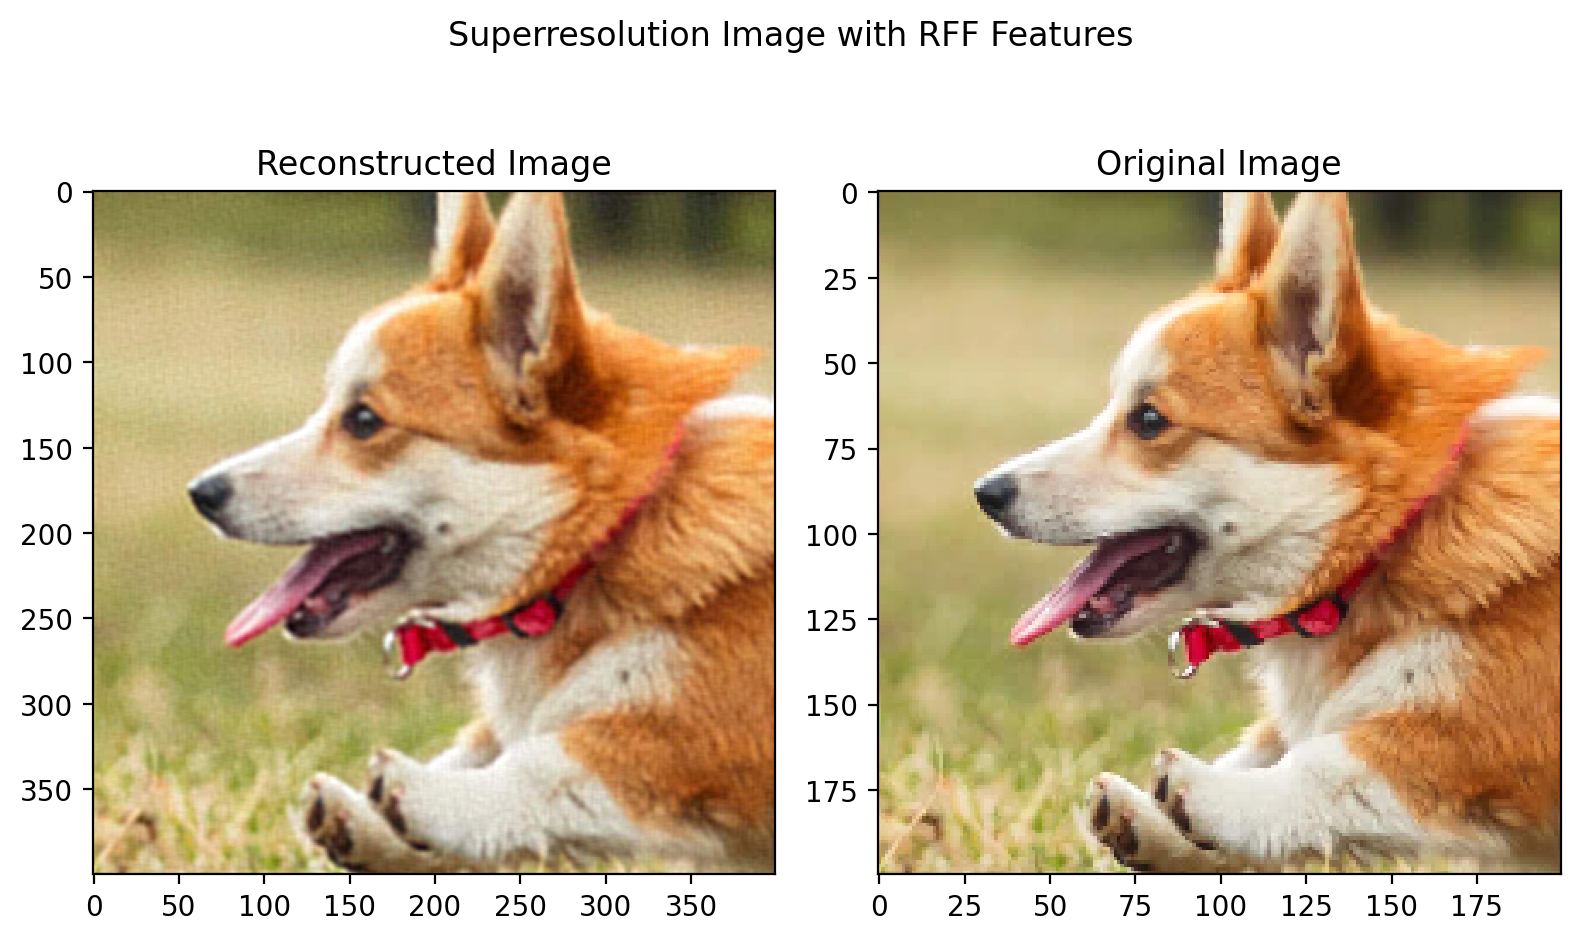

In [27]:
plot_reconstructed_and_original_image(max_pooled, net, X_rff, title = "Superresolution Image with RFF Features", scale = 2, allowSave = True, fileName = "./SIREN1Dog/Superresolution.png")

#### $$ \text{PSNR} = 20 \log_{10}(\frac{\text{MAX}_I}{\sqrt{\text{MSE}}})$$

In [28]:
def metrics(img1, img2, max_value = 1.0):
    rmse = torch.sqrt(F.mse_loss(img1, img2))
    psnr_value = 20 * torch.log10(max_value / rmse)
    return rmse, psnr_value.item()

In [29]:
def predict_plot(original_img, net, X):
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    
    rmse, psnr = metrics(original_img, rearrange(outputs, "h w c -> c h w"))
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw = {"width_ratios": [1, 1]}, figsize = (10, 6))
    fig.suptitle("Reconstruction using RFF" "\n" f"RMSE : {rmse} | PSNR : {psnr}", fontsize = 10)                                                  
    ax[0].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
    ax[0].set_title(fr"Ground Truth Image $({height} \times {width})$")
    ax[0].axis("off")
    ax[1].imshow(outputs.cpu().detach().numpy())
    ax[1].set_title(fr"Superresolution Reconstructed Image $({height} \times {width})$")
    ax[1].axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


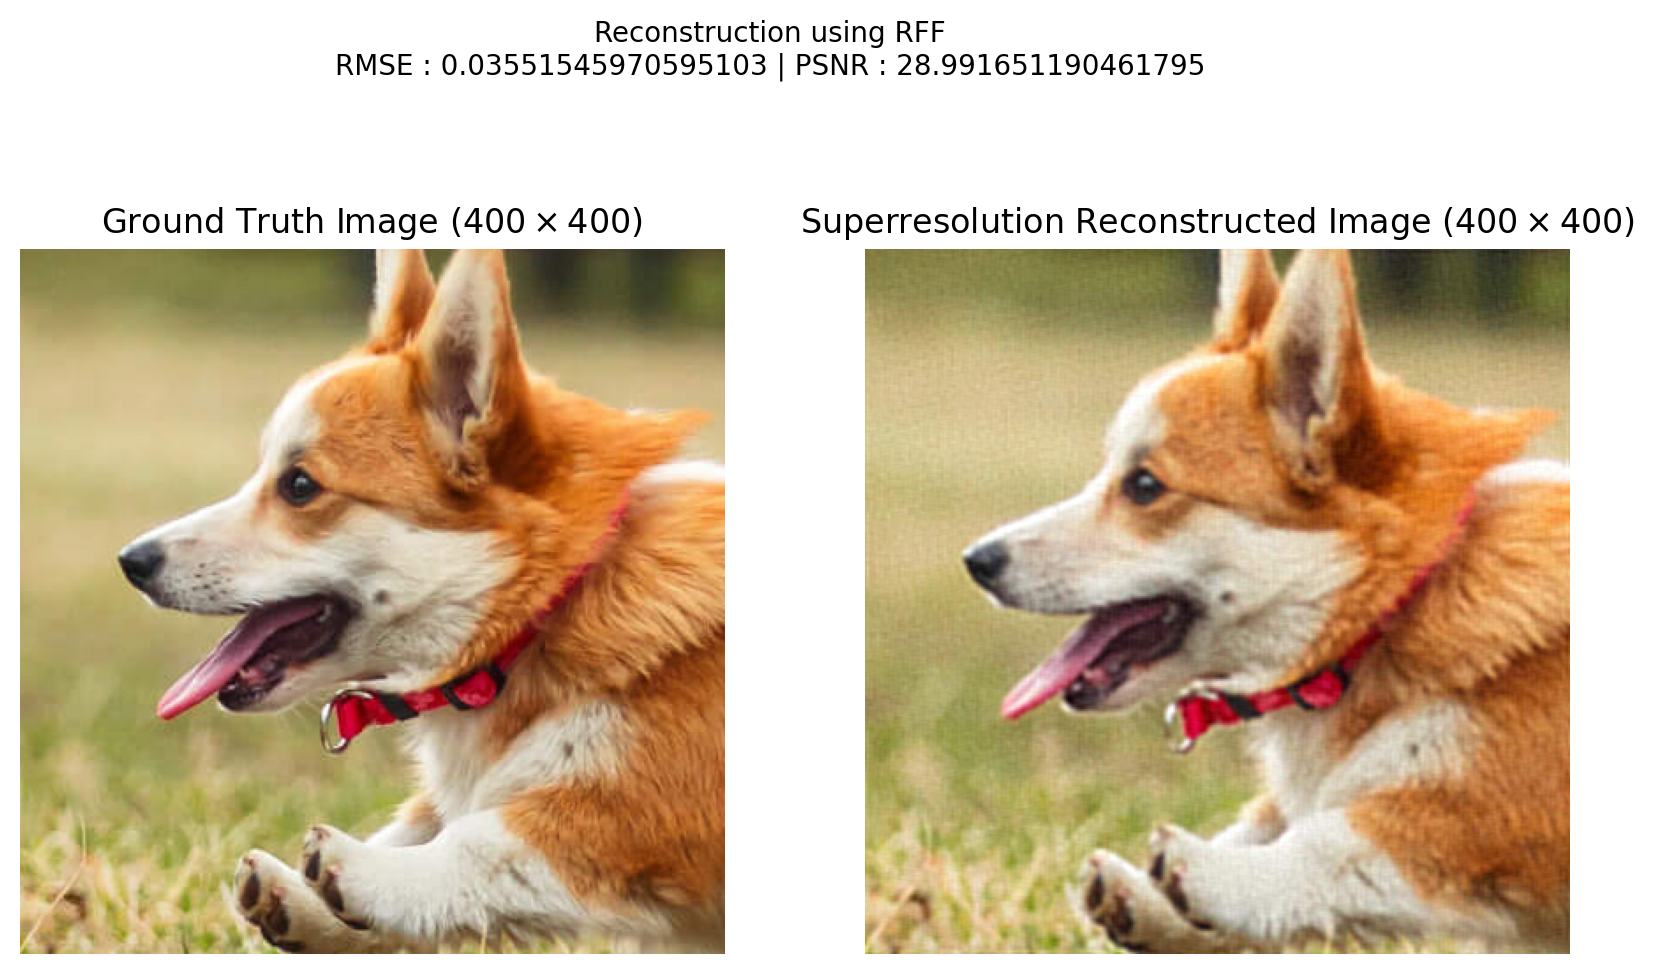

In [30]:
predict_plot(crop, net, X_rff)